# Importing the Libraries

In [2]:

#Import Standard Data Analysis Libraries
import datetime
import numpy as np
import pandas as pd
import re
import scipy.io

#Import dill library to save variables generated
import dill
import pickle
import path
import os

#import a plotting component
import matplotlib.pyplot as plt



# Setting the Directory

In [3]:
import sys
sys.path.append('Code Files')
sys.path.append('Data')

In [5]:

#n_train: number of training data samples
#n_test: number of test data samples
#tensor_dimensions: The dimensionality of the tensor.
#tensor_mode_ranks: Ranks along each mode of tensor
#separation_rank: S for LSR Decomposition

### CODE FOR DATA GENERATION

import numpy as np

#n_train: number of training data samples
#n_test: number of test data samples
#tensor_dimensions: The dimensionality of the tensor.
#tensor_mode_ranks: Ranks along each mode of tensor
#separation_rank: S for LSR Decomposition
#if intercept =! 0 then the synthetic data is not centered

def generate_data(n_train, n_test, tensor_dimensions: np.ndarray,\
                  tensor_mode_ranks: np.ndarray, separation_rank, intercept = 0):

    #Calculate number of tensor dimensions
    D = len(tensor_dimensions)

    #generating the training and testing together
    output_tensor_shape = tuple(np.append(n_train + n_test , tensor_dimensions))

    #Generate Core Tensor
    size = np.prod(tensor_mode_ranks)
    G1 = np.random.normal(0, 1, size)
    G1 = G1.reshape(tensor_mode_ranks)
    G1 = G1 / np.linalg.norm(G1, ord = 'fro')

    #generating the factor matrices
    all_factor_matrices=[]
    for s in range (separation_rank):
        mode_s_factormatrices = []
        for k in range(D):
            dummy_mat = np.random.normal(0, 1, size = (tensor_dimensions[k], tensor_mode_ranks[k]) )
            mode_s_factormatrices.append(dummy_mat)
        all_factor_matrices.append(mode_s_factormatrices)

    print('Initiallizng Core Tensor and Factor Matrices: Done')

    #Using the Factor Matrices and Core Tensor, Generate B
    B_tensor_prior_N = np.zeros(tensor_dimensions)
    for s in range(separation_rank):
        B_tensor_prior_N += all_factor_matrices[s][0] @ G1 @ all_factor_matrices[s][1].T

    # Normalizing

    #norms = np.linalg.norm(B_tensor_prior_N, ord = 'fro')
    B_tensor = B_tensor_prior_N #/norms

    print('Generating the Parameter Tensor: Done')

    #Generate X
    X = np.random.normal(5,0.5,size=(output_tensor_shape)) # can this affect we are drawing all the points for the covariates at once

    #generating the dependent variable
    B_tensor_flatten = B_tensor.flatten(order ='F')
    X_transpose = np.transpose(X, (0,2,1))
    X_transpose_vectorized = np.reshape(X_transpose, newshape = (X_transpose.shape[0],-1))
    y_no_noise = np.dot(X_transpose_vectorized, B_tensor_flatten) + intercept
    y = y_no_noise + np.random.normal(0, 0.01, size = y_no_noise.shape)
    print('Generating Data: Done')
    if intercept != 0:
       print('Data generated with an intercept')

    #Split into X_train, X_test, Y_train,Y_test
    X_train = X[:n_train]
    X_test  = X[n_train:n_train+n_test]
    y_train = y[:n_train]
    y_test  = y[n_train:n_train+n_test]
    print('Splitting into Train/Test: Done')

    return X_train, y_train, X_test, y_test, B_tensor,G1,all_factor_matrices,y_no_noise

In [13]:
# Function to mean and the energy


def mean_energy(A):
  mean    = np.mean(A)
  energy  = np.sum((A-mean)**2)/(np.size(A)-1)  # cause we are calculating the energy of a sample from the population we use n-1
  return mean, energy


In [6]:
n_train = 5000
n_test = 1000

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2
intercept = 0


X_train_all, Y_train_all, X_test, Y_test, B_tensored,G1,all_factormatrices,Y_train_nonoise = generate_data(n_train, n_test, tensor_dimensions, tensor_mode_ranks, separation_rank, intercept= intercept)



Initiallizng Core Tensor and Factor Matrices: Done
Generating the Parameter Tensor: Done
Generating Data: Done
Splitting into Train/Test: Done


In [10]:
#saving the data needed
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Data/Bounded_Var_Time:{formatted_time}, intercept:{5},n_train:{n_train}, n_test:{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}.pkl"
with open(pkl_file, "wb") as file:
    dill.dump((X_train_all, Y_train_all, X_test, Y_test, B_tensored,G1,all_factormatrices,Y_train_nonoise), file)

### When reusing the data do it from here.

In [ ]:
import pickle

file= open("/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Data/Bounded_Var_Time:2024-04-15 19:35:40, intercept:5,n_train:5000, n_test:1000, tensor_dimensions:[32 32], tensor_mode_ranks:[4 4], separation_rank:2.pkl", 'rb')
data = pickle.load(file)
file.close()

X_train = data[0]
print(data[0].shape)

Y_train = data[1]
print(data[1].shape)

X_test = data[2]
print(data[2].shape)

Y_test = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

G1 = data[5]
print(data[5].shape)

all_factormatrices = data[6]
#print(data[6].shape)

Y_train_nonoise = data[7]
print(data[7].shape)


(5000, 16, 16)
(5000,)
(1000, 16, 16)
(1000,)
(16, 16)
(4, 4)
(6000,)


Factor Matrix 0 0
mean 0.01184541310811367 energy 0.9600946035945641



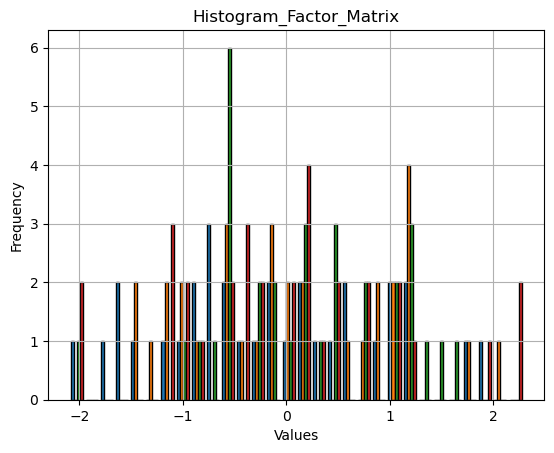

Factor Matrix 0 1
mean 0.019134003141667102 energy 0.6537952587146879



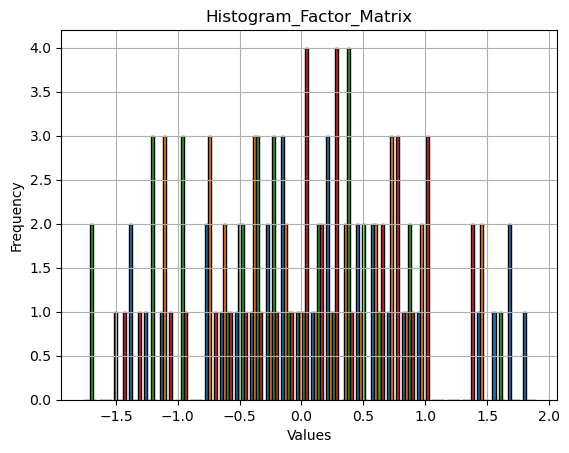

Factor Matrix 1 0
mean -0.13312041673920116 energy 0.8847768486141238



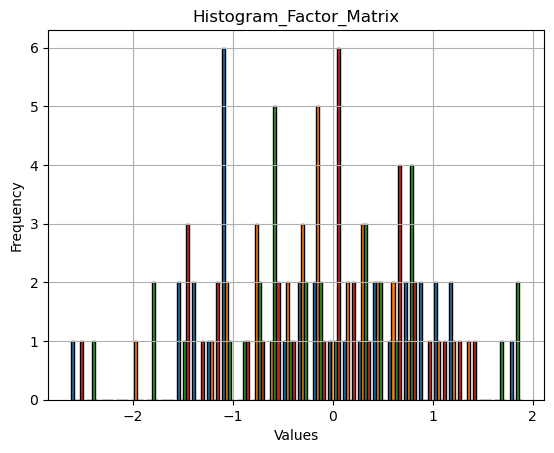

Factor Matrix 1 1
mean 0.04630961619847291 energy 0.9688538024460024



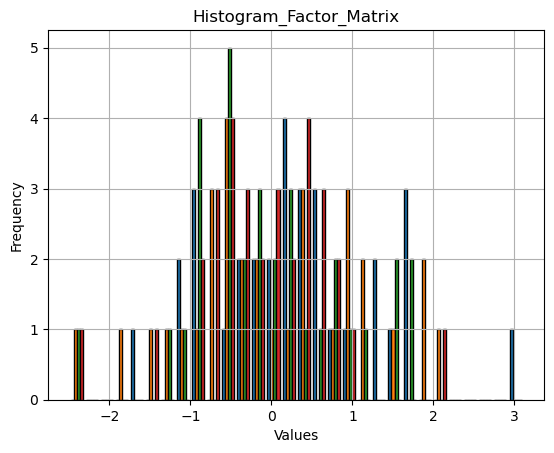

Core Tensor
mean -0.03528249276067848 energy: 0.06533882208489884



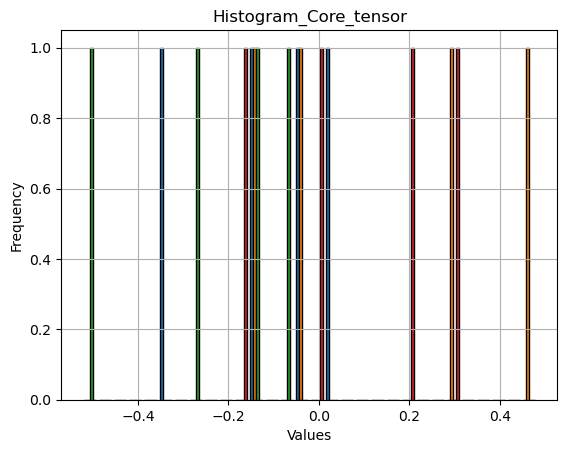

In [23]:
#factor to numpy

#all_fac_nd = []
#for s, term_s_factors in enumerate(all_factormatrices):
#  for k, term_k_factors in enumerate(term_s_factors):
#            term_s_factors_ndarray = [param.data.numpy() for param in term_s_factors]
#  all_fac_nd.append(term_s_factors_ndarray)

for s,term_s_factors in enumerate(all_factormatrices):
  for k,factor in enumerate(term_s_factors):
    print('Factor Matrix',s,k)
    Fac_mean, Fac_energy = mean_energy(factor)
    print('mean',Fac_mean,'energy',Fac_energy)
    print('')
    # Plot the histogram
    plt.hist(factor, bins=30, edgecolor='black')  # Adjust the number of bins as needed
    plt.title('Histogram_Factor_Matrix')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#core tensor

print('Core Tensor')
mean_G,energy_G = mean_energy(G1)
print('mean',mean_G,'energy:',energy_G)
print('')

# Plot the histogram
plt.hist(G1, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Core_tensor')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



2085.8982931691
LSR Tensor
mean 0.016163894250458895 energy: 2.0387397372202387



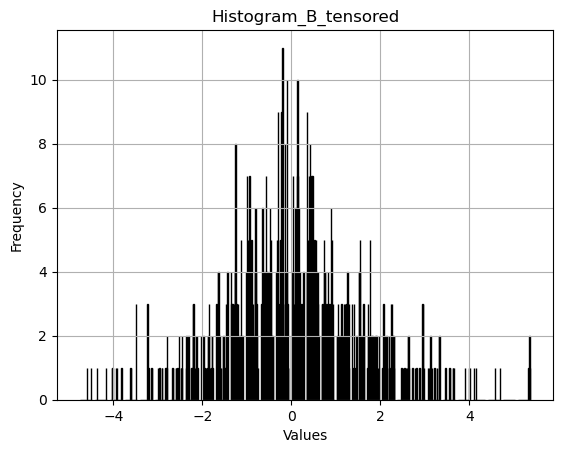

In [24]:

Norm_B = np.linalg.norm(B_tensored, ord = 'fro')
print(Norm_B**2)

print('LSR Tensor')
mean_B_ten,energy_B_ten = mean_energy(B_tensored)
print('mean',mean_B_ten,'energy:',energy_B_ten)
print('')

# Plot the histogram
plt.hist(B_tensored, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_B_tensored')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
#samples

for i in range (800):
    print('Sample',i)
    Fac_mean, Fac_energy = mean_energy(X_train_all[i,:,:])
    print('mean',Fac_mean,'energy',Fac_energy)
    print('')


All_mean, All_energy = mean_energy(X_train_all )
print('mean',All_mean,'energy:',All_energy)

Sample 0
mean 4.971326187803414 energy 0.25029140522998794

Sample 1
mean 4.9939531352163335 energy 0.26215638013192777

Sample 2
mean 5.012475880614328 energy 0.23519575624188183

Sample 3
mean 5.038121082837127 energy 0.24253428012724038

Sample 4
mean 4.983085304706185 energy 0.2581660506942151

Sample 5
mean 4.999000846624538 energy 0.2567603410931991

Sample 6
mean 5.011479092552452 energy 0.2423769472050876

Sample 7
mean 4.984097351911633 energy 0.2573517254373084

Sample 8
mean 4.998170621302532 energy 0.2593423135457847

Sample 9
mean 5.019440313702546 energy 0.26328896913010225

Sample 10
mean 5.006082167613793 energy 0.23731954270071212

Sample 11
mean 5.001014424310913 energy 0.23562550242051203

Sample 12
mean 5.000914693031559 energy 0.23812142080172108

Sample 13
mean 5.02974479846525 energy 0.23826746578081354

Sample 14
mean 5.037560625317164 energy 0.2478504648137372

Sample 15
mean 5.019383807316514 energy 0.2706494940719492

Sample 16
mean 4.984100214554518 energy 0

<B,X>_training
mean 83.03273181302477 energy: 523.0083626680495



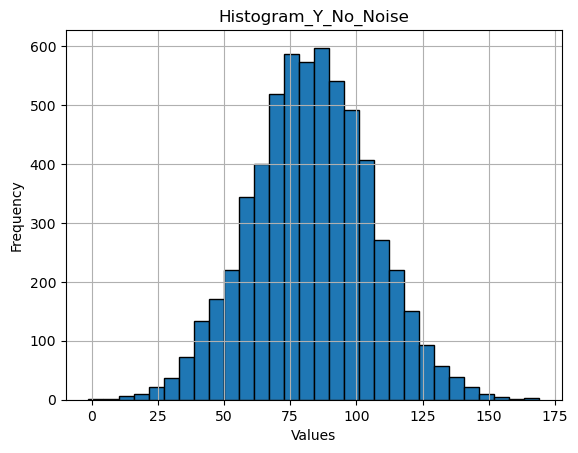

In [26]:
#No_noise

print('<B,X>_training')
mean_T_train_no,energy_T_train_no = mean_energy(Y_train_nonoise)
print('mean',mean_T_train_no,'energy:',energy_T_train_no)
print('')

# Plot the histogram
plt.hist(Y_train_nonoise, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_No_Noise')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

training
mean 82.87999206996591 energy: 527.8695603049093



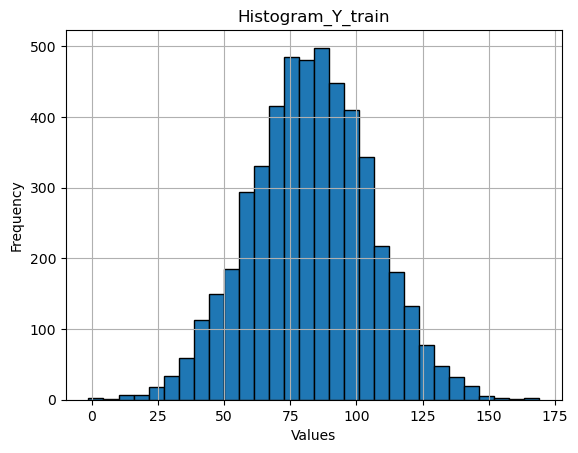

In [44]:
#training
Y_train = Y_train_all
print('training')
mean_Y,energy_Y = mean_energy(Y_train)
print('mean',mean_Y,'energy:',energy_Y)
print('')

# Plot the histogram
plt.hist(Y_train, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_train')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#still we have the error of mean shift and variance

testing
mean 83.79787003248885 energy: 498.5081579692903



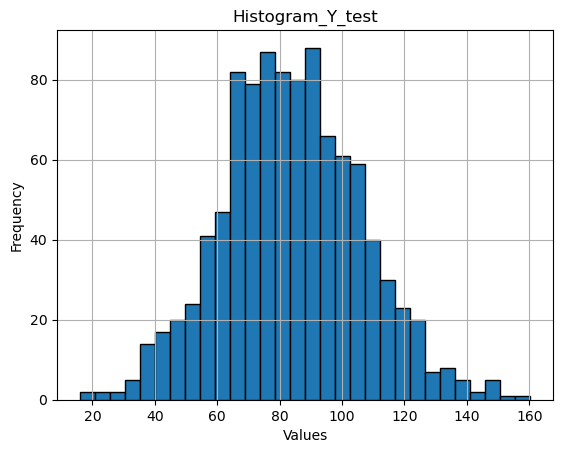

In [50]:
#testing
print('testing')
mean_Y_test,energy_Y_test = mean_energy(Y_test)
print('mean',mean_Y_test,'energy:',energy_Y_test)
print('')

# Plot the histogram
plt.hist(Y_test, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_test')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()